In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator

from keras.utils import plot_model

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('fer2013.csv') #Reading the FER2013 dataset
# data = data[data['emotion']!=1] #Kicking disgust out
new_emo_num_map = {0: 0, 1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5} #remapping as 6 to 1
data['emotion'] = data['emotion'].map(new_emo_num_map)
# data

In [ ]:
# emotion_map = {0: 'Angry', 1: 'Neutral', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise'}
# emotion_counts = data['emotion'].value_counts(sort = False).reset_index()
# emotion_counts.columns = ['emotion', 'number']
# emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)

# emotion_counts

In [ ]:
# plt.figure()
# # print('\n')
# sns.barplot(emotion_counts.emotion, emotion_counts.number)
# plt.title('Class distribution')
# plt.ylabel('Number of Sample')
# plt.xlabel('Emotional Status')

In [3]:
def CRNO(df):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    #pixel_sequence = df['pixels']
    #df['pixels'] = [int(pixel) for pixel in pixel_sequence.split()]
    data_X = np.array(df['pixels'].tolist(), dtype = 'float32').reshape(-1, width, height, 1)/255.0
    data_Y = to_categorical(df['emotion'], num_classes)
    return data_X, data_Y

In [2]:
# data = pd.read_csv('fer2013.csv')

In [4]:
data_generator = ImageDataGenerator(featurewise_center = True, #False,
                                    featurewise_std_normalization = False,
                                    rotation_range = 20,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    zoom_range = 0.3,
                                    horizontal_flip = True)

# es = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)
# es = EarlyStopping(monitor = 'val_accuracy', patience = 30, mode = 'max', restore_best_weights = True)

In [5]:
num_classes = 6 #Disgust out
width, height = 48, 48
num_epochs = 100
batch_size = 64
num_features = 64

In [6]:
fold_number = 5

In [7]:
data['KFold'] = range(len(data))
data['KFold'] = data['KFold']%fold_number
data.drop('Usage', inplace= True, axis= 1)

In [9]:
for kf in range(fold_number):
    data_train = data[data['KFold'] != kf].copy()
    data_val = data[data['KFold'] == kf].copy()
    
    print(data_train.shape, data_val.shape)
    
    train_X, train_Y = CRNO(data_train)
    val_X, val_Y = CRNO(data_val)
    
    model = Sequential()

    #module 1
    model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding = 'same', input_shape=((width, height, 1)), data_format='channels_last'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    #module 2
    model.add(Conv2D(4*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(4*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    #module 3
    model.add(Conv2D(8*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(8*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    #flatten
    model.add(Flatten())

    #dense 1
    model.add(Dense(16*num_features))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    #dense 2
    model.add(Dense(16*num_features))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    #dense 3
    model.add(Dense(num_features))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    #output layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), #lr= 0.001
                  metrics=['accuracy'])

#     model.summary()
    
    history = model.fit(data_generator.flow(train_X, train_Y, batch_size),
                    steps_per_epoch = len(train_X) / batch_size,
                    epochs = num_epochs,
                    verbose = 1,
                    callbacks = [es],
                    validation_data = (val_X, val_Y))
    
    score = model.evaluate(val_X, val_Y, verbose=1)
    print(score[1])
#     scorelist.append(score[1])
    
    # Creating and saving confusion matrix
    pred_Y=model.predict(val_X)
    tesst_Y=np.argmax(val_Y, axis=1)
    pred_Y=np.argmax(pred_Y,axis=1)
    cmatrix=confusion_matrix(tesst_Y, pred_Y)
    cmatrix = cmatrix.astype('float')/cmatrix.sum(axis=1)[:, np.newaxis]
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cmatrix, annot=True, fmt= '.2f', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

(28709, 3) (7178, 3)


KeyboardInterrupt: 

In [7]:
# chk_path = 'ferNet.h5'
# log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# checkpoint = ModelCheckpoint(filepath=chk_path,
#                              save_best_only=True,
#                              verbose=1,
#                              mode='min',
#                              moniter='val_loss')

# earlystop = EarlyStopping(monitor='val_loss', 
#                           min_delta=0, 
#                           patience=3, 
#                           verbose=1, 
#                           restore_best_weights=True)
                        
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
#                               factor=0.2, 
#                               patience=6, 
#                               verbose=1, 
#                               min_delta=0.0001)


# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
# csv_logger = CSVLogger('training.log')

# callbacks = [checkpoint, reduce_lr, csv_logger]

(28709, 3) (7178, 3)

Epoch 00001: val_loss improved from inf to 1.76991, saving model to 5_fold_iter\ferNet_1.h5

Epoch 00002: val_loss improved from 1.76991 to 1.68592, saving model to 5_fold_iter\ferNet_1.h5

Epoch 00003: val_loss improved from 1.68592 to 1.63820, saving model to 5_fold_iter\ferNet_1.h5

Epoch 00004: val_loss did not improve from 1.63820

Epoch 00005: val_loss improved from 1.63820 to 1.54296, saving model to 5_fold_iter\ferNet_1.h5

Epoch 00006: val_loss improved from 1.54296 to 1.48171, saving model to 5_fold_iter\ferNet_1.h5

Epoch 00007: val_loss did not improve from 1.48171

Epoch 00008: val_loss improved from 1.48171 to 1.36668, saving model to 5_fold_iter\ferNet_1.h5

Epoch 00009: val_loss improved from 1.36668 to 1.26382, saving model to 5_fold_iter\ferNet_1.h5

Epoch 00010: val_loss improved from 1.26382 to 1.22105, saving model to 5_fold_iter\ferNet_1.h5

Epoch 00011: val_loss did not improve from 1.22105

Epoch 00012: val_loss improved from 1.22105 to 1.1


Epoch 00014: val_loss improved from 1.17521 to 1.12011, saving model to 5_fold_iter\ferNet_2.h5

Epoch 00015: val_loss improved from 1.12011 to 1.08763, saving model to 5_fold_iter\ferNet_2.h5

Epoch 00016: val_loss did not improve from 1.08763

Epoch 00017: val_loss did not improve from 1.08763

Epoch 00018: val_loss did not improve from 1.08763

Epoch 00019: val_loss did not improve from 1.08763

Epoch 00020: val_loss improved from 1.08763 to 1.08079, saving model to 5_fold_iter\ferNet_2.h5

Epoch 00021: val_loss improved from 1.08079 to 0.98324, saving model to 5_fold_iter\ferNet_2.h5

Epoch 00022: val_loss did not improve from 0.98324

Epoch 00023: val_loss did not improve from 0.98324

Epoch 00024: val_loss did not improve from 0.98324

Epoch 00025: val_loss did not improve from 0.98324

Epoch 00026: val_loss improved from 0.98324 to 0.96131, saving model to 5_fold_iter\ferNet_2.h5

Epoch 00027: val_loss improved from 0.96131 to 0.95241, saving model to 5_fold_iter\ferNet_2.h5

E


Epoch 00029: val_loss did not improve from 0.92199

Epoch 00030: val_loss did not improve from 0.92199

Epoch 00031: val_loss did not improve from 0.92199

Epoch 00032: val_loss did not improve from 0.92199

Epoch 00033: val_loss did not improve from 0.92199

Epoch 00033: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 00034: val_loss improved from 0.92199 to 0.89838, saving model to 5_fold_iter\ferNet_3.h5

Epoch 00035: val_loss improved from 0.89838 to 0.88354, saving model to 5_fold_iter\ferNet_3.h5

Epoch 00036: val_loss did not improve from 0.88354

Epoch 00037: val_loss did not improve from 0.88354

Epoch 00038: val_loss did not improve from 0.88354

Epoch 00039: val_loss did not improve from 0.88354

Epoch 00040: val_loss did not improve from 0.88354

Epoch 00041: val_loss improved from 0.88354 to 0.87148, saving model to 5_fold_iter\ferNet_3.h5

Epoch 00042: val_loss did not improve from 0.87148

Epoch 00043: val_loss did not improve from 0.87148

Ep


Epoch 00046: val_loss improved from 0.86341 to 0.86199, saving model to 5_fold_iter\ferNet_4.h5

Epoch 00047: val_loss did not improve from 0.86199

Epoch 00048: val_loss did not improve from 0.86199

Epoch 00049: val_loss did not improve from 0.86199

Epoch 00050: val_loss improved from 0.86199 to 0.86033, saving model to 5_fold_iter\ferNet_4.h5

Epoch 00051: val_loss did not improve from 0.86033

Epoch 00052: val_loss did not improve from 0.86033

Epoch 00053: val_loss did not improve from 0.86033

Epoch 00054: val_loss did not improve from 0.86033

Epoch 00055: val_loss did not improve from 0.86033

Epoch 00056: val_loss did not improve from 0.86033

Epoch 00056: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.

Epoch 00057: val_loss did not improve from 0.86033

Epoch 00058: val_loss did not improve from 0.86033

Epoch 00059: val_loss did not improve from 0.86033

Epoch 00060: val_loss did not improve from 0.86033

Epoch 00061: val_loss did not improve from 0.860


Epoch 00064: val_loss did not improve from 0.86599

Epoch 00065: val_loss did not improve from 0.86599

Epoch 00066: val_loss did not improve from 0.86599

Epoch 00066: ReduceLROnPlateau reducing learning rate to 3.199999980552093e-08.

Epoch 00067: val_loss did not improve from 0.86599

Epoch 00068: val_loss did not improve from 0.86599

Epoch 00069: val_loss did not improve from 0.86599

Epoch 00070: val_loss did not improve from 0.86599

Epoch 00071: val_loss did not improve from 0.86599

Epoch 00072: val_loss did not improve from 0.86599

Epoch 00072: ReduceLROnPlateau reducing learning rate to 6.399999818995639e-09.

Epoch 00073: val_loss did not improve from 0.86599

Epoch 00074: val_loss did not improve from 0.86599

Epoch 00075: val_loss did not improve from 0.86599

Epoch 00076: val_loss did not improve from 0.86599

Epoch 00077: val_loss did not improve from 0.86599

Epoch 00078: val_loss did not improve from 0.86599

Epoch 00078: ReduceLROnPlateau reducing learning rate to 

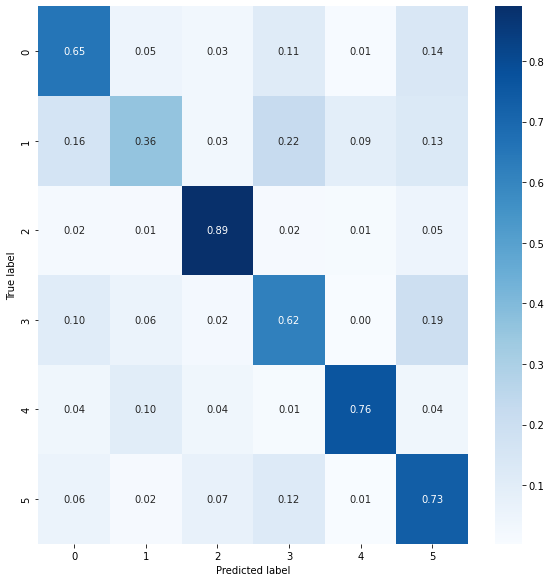

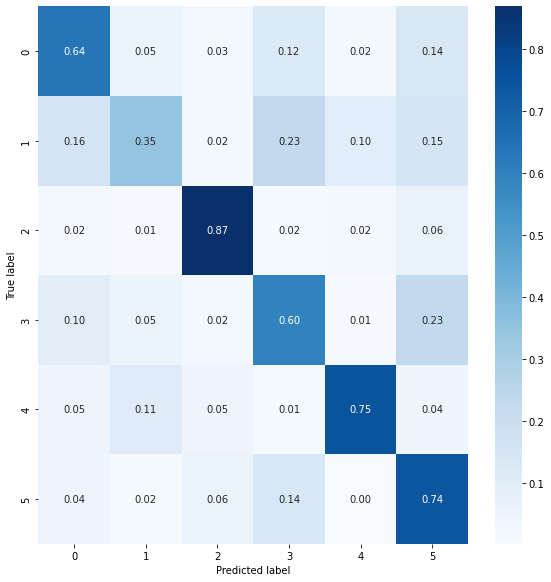

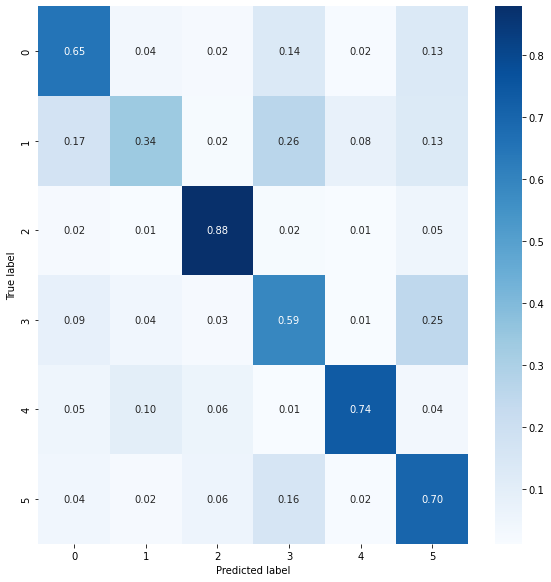

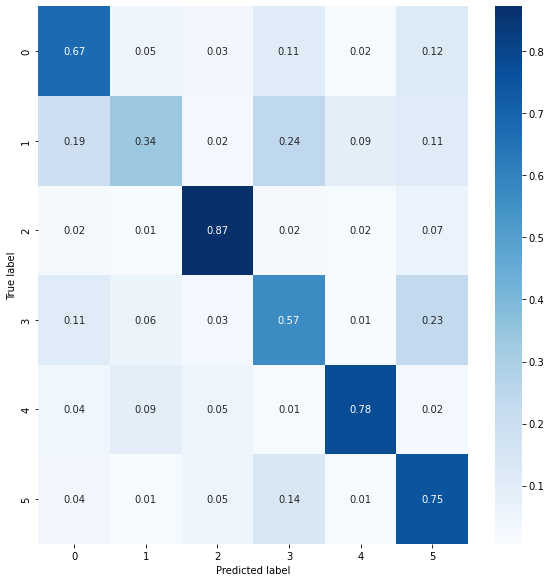

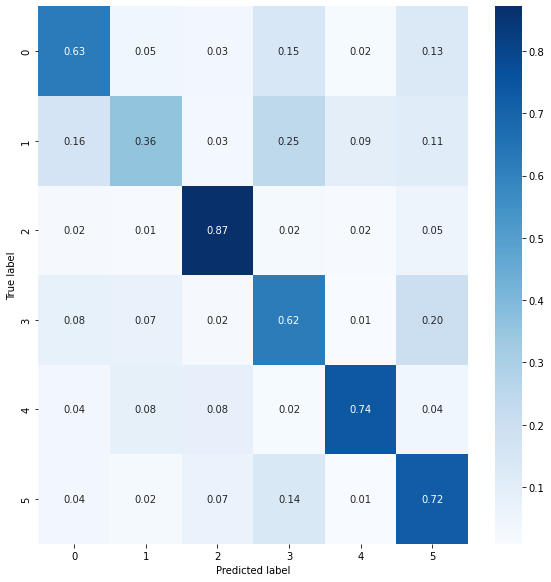

In [10]:
scorelist = []

for kf in range(fold_number):
    data_train = data[data['KFold'] != kf].copy()
    data_val = data[data['KFold'] == kf].copy()
    
    print(data_train.shape, data_val.shape)
    
    train_X, train_Y = CRNO(data_train)
    val_X, val_Y = CRNO(data_val)
    
    model = Sequential()

    #module 1
    model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding = 'same', input_shape=((width, height, 1)), data_format='channels_last'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    #module 2
    model.add(Conv2D(4*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(4*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    #module 3
    model.add(Conv2D(8*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(8*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    #flatten
    model.add(Flatten())

    #dense 1
    model.add(Dense(16*num_features))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    #dense 2
    model.add(Dense(16*num_features))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    #dense 3
    model.add(Dense(num_features))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    #output layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(lr=0.0001, decay=1e-6), #Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), #lr= 0.001
                  metrics=['accuracy'])

    # model.summary()
    # plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
    
    
    chk_path = '5_fold_iter/ferNet_'+str(kf+1)+'.h5'
    log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

    earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    csv_logger = CSVLogger('5_fold_iter/training_'+str(kf+1)+'.log')

    callbacks = [checkpoint, reduce_lr, csv_logger]
    
    history = model.fit(data_generator.flow(train_X, train_Y, batch_size),
                        steps_per_epoch = len(train_X) / batch_size,
                        epochs = num_epochs,
                        verbose = 0,
                        callbacks = callbacks, #[es],
                        validation_data = (val_X, val_Y),
                        validation_steps=len(val_X) / batch_size)
    
    score = model.evaluate(val_X, val_Y, verbose=1)
    print(score[1])
    scorelist.append(score[1])
    
    # Creating and saving confusion matrix
    pred_Y=model.predict(val_X)
    tesst_Y=np.argmax(val_Y, axis=1)
    pred_Y=np.argmax(pred_Y,axis=1)
    cmatrix=confusion_matrix(tesst_Y, pred_Y)
    cmatrix = cmatrix.astype('float')/cmatrix.sum(axis=1)[:, np.newaxis]
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cmatrix, annot=True, fmt= '.2f', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('5_fold_iter/Confusion_'+str(kf+1)+'_val_acc_'+str(score[1])+'_5_fold.png')

    # Saving the models
    # model.save('10_fold_iter/model_10_fold_iter_KF_'+ str(kf+1) + '.h5')



np.savetxt("5_fold_iter/test_accuracy.csv", scorelist, delimiter =",")

(28709, 3) (7178, 3)

Epoch 00001: val_loss improved from inf to 6.99176, saving model to 5_fold_iter\ferNet_1.h5

Epoch 00002: val_loss improved from 6.99176 to 3.12325, saving model to 5_fold_iter\ferNet_1.h5

Epoch 00003: val_loss improved from 3.12325 to 2.65471, saving model to 5_fold_iter\ferNet_1.h5

Epoch 00004: val_loss improved from 2.65471 to 2.32235, saving model to 5_fold_iter\ferNet_1.h5

Epoch 00005: val_loss improved from 2.32235 to 2.13671, saving model to 5_fold_iter\ferNet_1.h5

Epoch 00006: val_loss improved from 2.13671 to 1.84537, saving model to 5_fold_iter\ferNet_1.h5

Epoch 00007: val_loss did not improve from 1.84537

Epoch 00008: val_loss improved from 1.84537 to 1.57252, saving model to 5_fold_iter\ferNet_1.h5

Epoch 00009: val_loss improved from 1.57252 to 1.45932, saving model to 5_fold_iter\ferNet_1.h5

Epoch 00010: val_loss improved from 1.45932 to 1.32796, saving model to 5_fold_iter\ferNet_1.h5

Epoch 00011: val_loss did not improve from 1.32796

Epoch


Epoch 00010: val_loss improved from 1.45999 to 1.37010, saving model to 5_fold_iter\ferNet_2.h5

Epoch 00011: val_loss improved from 1.37010 to 1.32593, saving model to 5_fold_iter\ferNet_2.h5

Epoch 00012: val_loss improved from 1.32593 to 1.27852, saving model to 5_fold_iter\ferNet_2.h5

Epoch 00013: val_loss did not improve from 1.27852

Epoch 00014: val_loss improved from 1.27852 to 1.25889, saving model to 5_fold_iter\ferNet_2.h5

Epoch 00015: val_loss improved from 1.25889 to 1.22864, saving model to 5_fold_iter\ferNet_2.h5

Epoch 00016: val_loss improved from 1.22864 to 1.21539, saving model to 5_fold_iter\ferNet_2.h5

Epoch 00017: val_loss improved from 1.21539 to 1.20912, saving model to 5_fold_iter\ferNet_2.h5

Epoch 00018: val_loss improved from 1.20912 to 1.16528, saving model to 5_fold_iter\ferNet_2.h5

Epoch 00019: val_loss improved from 1.16528 to 1.14872, saving model to 5_fold_iter\ferNet_2.h5

Epoch 00020: val_loss did not improve from 1.14872

Epoch 00021: val_loss 


Epoch 00019: val_loss did not improve from 1.13842

Epoch 00020: val_loss improved from 1.13842 to 1.13659, saving model to 5_fold_iter\ferNet_3.h5

Epoch 00021: val_loss did not improve from 1.13659

Epoch 00022: val_loss did not improve from 1.13659

Epoch 00023: val_loss did not improve from 1.13659

Epoch 00024: val_loss improved from 1.13659 to 1.12187, saving model to 5_fold_iter\ferNet_3.h5

Epoch 00025: val_loss did not improve from 1.12187

Epoch 00026: val_loss improved from 1.12187 to 1.11228, saving model to 5_fold_iter\ferNet_3.h5

Epoch 00027: val_loss improved from 1.11228 to 1.11062, saving model to 5_fold_iter\ferNet_3.h5

Epoch 00028: val_loss improved from 1.11062 to 1.09707, saving model to 5_fold_iter\ferNet_3.h5

Epoch 00029: val_loss improved from 1.09707 to 1.09324, saving model to 5_fold_iter\ferNet_3.h5

Epoch 00030: val_loss improved from 1.09324 to 1.07643, saving model to 5_fold_iter\ferNet_3.h5

Epoch 00031: val_loss improved from 1.07643 to 1.05797, savi


Epoch 00032: val_loss did not improve from 1.05665

Epoch 00033: val_loss improved from 1.05665 to 1.04442, saving model to 5_fold_iter\ferNet_4.h5

Epoch 00034: val_loss improved from 1.04442 to 1.03479, saving model to 5_fold_iter\ferNet_4.h5

Epoch 00035: val_loss did not improve from 1.03479

Epoch 00036: val_loss did not improve from 1.03479

Epoch 00037: val_loss did not improve from 1.03479

Epoch 00038: val_loss did not improve from 1.03479

Epoch 00039: val_loss did not improve from 1.03479

Epoch 00040: val_loss did not improve from 1.03479

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 00041: val_loss improved from 1.03479 to 1.00245, saving model to 5_fold_iter\ferNet_4.h5

Epoch 00042: val_loss did not improve from 1.00245

Epoch 00043: val_loss did not improve from 1.00245

Epoch 00044: val_loss did not improve from 1.00245

Epoch 00045: val_loss improved from 1.00245 to 0.99458, saving model to 5_fold_iter\ferNet_4.h5

Epoch 000


Epoch 00044: val_loss improved from 1.05123 to 1.02895, saving model to 5_fold_iter\ferNet_5.h5

Epoch 00045: val_loss did not improve from 1.02895

Epoch 00046: val_loss did not improve from 1.02895

Epoch 00047: val_loss improved from 1.02895 to 1.01766, saving model to 5_fold_iter\ferNet_5.h5

Epoch 00048: val_loss improved from 1.01766 to 1.01413, saving model to 5_fold_iter\ferNet_5.h5

Epoch 00049: val_loss improved from 1.01413 to 1.01207, saving model to 5_fold_iter\ferNet_5.h5

Epoch 00050: val_loss did not improve from 1.01207

Epoch 00051: val_loss improved from 1.01207 to 1.00786, saving model to 5_fold_iter\ferNet_5.h5

Epoch 00052: val_loss did not improve from 1.00786

Epoch 00053: val_loss did not improve from 1.00786

Epoch 00054: val_loss improved from 1.00786 to 0.99612, saving model to 5_fold_iter\ferNet_5.h5

Epoch 00055: val_loss did not improve from 0.99612

Epoch 00056: val_loss did not improve from 0.99612

Epoch 00057: val_loss did not improve from 0.99612

E

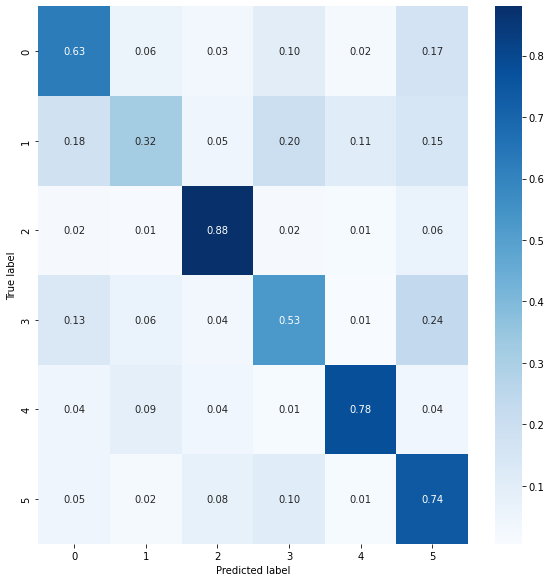

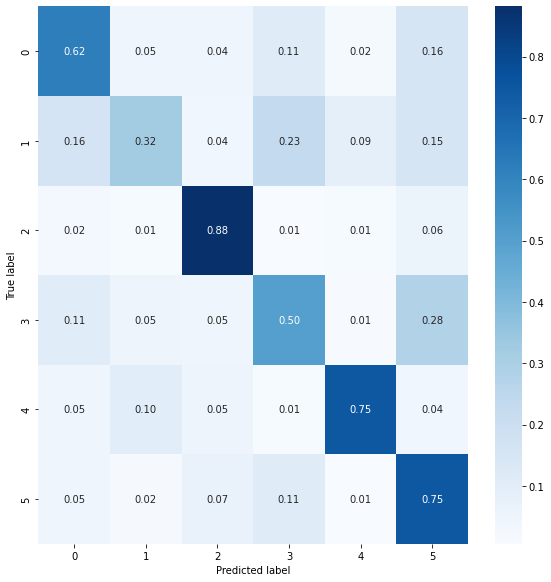

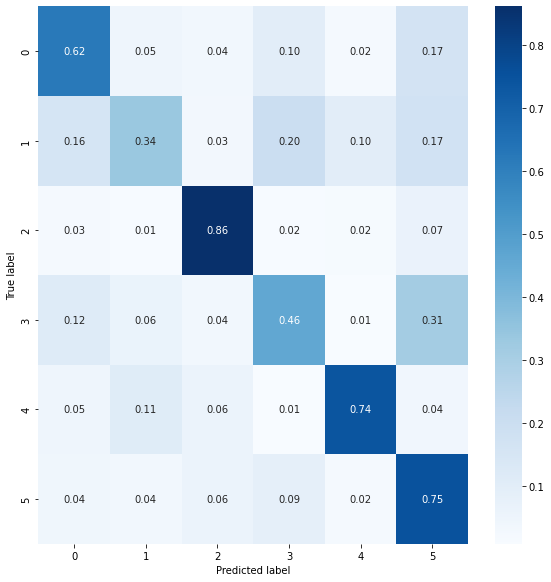

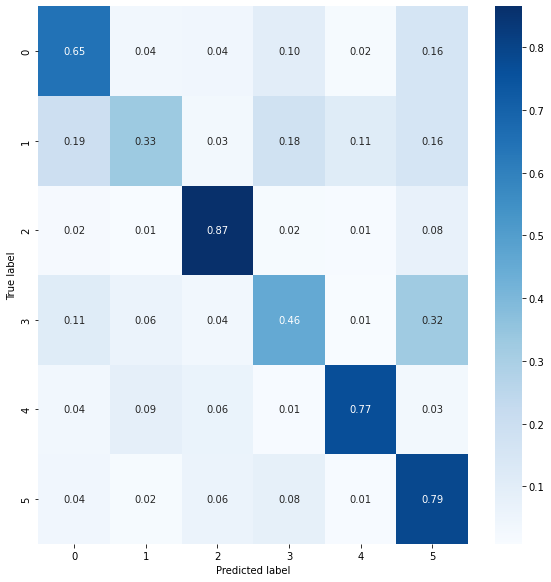

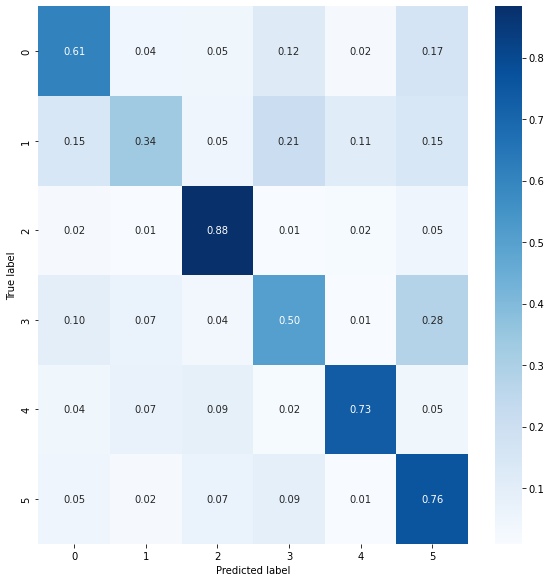

In [8]:
scorelist = []

for kf in range(fold_number):
    data_train = data[data['KFold'] != kf].copy()
    data_val = data[data['KFold'] == kf].copy()
    
    print(data_train.shape, data_val.shape)
    
    train_X, train_Y = CRNO(data_train)
    val_X, val_Y = CRNO(data_val)
    
    model = Sequential()
    
    # Conv Layer 1
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =((width, height, 1)), data_format='channels_last'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    # Conv Layer 2
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Dense Layer 1
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    #output layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(lr=0.0001, decay=1e-6), #Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), #lr= 0.001
                  metrics=['accuracy'])

    # model.summary()
    # plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
    
    
    chk_path = '5_fold_iter/ferNet_'+str(kf+1)+'.h5'
    log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

    earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    csv_logger = CSVLogger('5_fold_iter/training_'+str(kf+1)+'.log')

    callbacks = [checkpoint, reduce_lr, csv_logger]
    
    history = model.fit(data_generator.flow(train_X, train_Y, batch_size),
                        steps_per_epoch = len(train_X) / batch_size,
                        epochs = num_epochs,
                        verbose = 0,
                        callbacks = callbacks, #[es],
                        validation_data = (val_X, val_Y),
                        validation_steps=len(val_X) / batch_size)
    
    score = model.evaluate(val_X, val_Y, verbose=1)
    print(score[1])
    scorelist.append(score[1])
    
    # Creating and saving confusion matrix
    pred_Y=model.predict(val_X)
    tesst_Y=np.argmax(val_Y, axis=1)
    pred_Y=np.argmax(pred_Y,axis=1)
    cmatrix=confusion_matrix(tesst_Y, pred_Y)
    cmatrix = cmatrix.astype('float')/cmatrix.sum(axis=1)[:, np.newaxis]
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cmatrix, annot=True, fmt= '.2f', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('5_fold_iter/Confusion_'+str(kf+1)+'_val_acc_'+str(score[1])+'_10_fold.png')

    # Saving the models
    # model.save('10_fold_iter/model_10_fold_iter_KF_'+ str(kf+1) + '.h5')



np.savetxt("5_fold_iter/test_accuracy.csv", scorelist, delimiter =",")